## Aligning Target to sketch

This code is used to align the scanned targets to the sketches

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Loop to find the centres of the red dots as coordiantes 

In [12]:
def center_dots(dot):
    
    
    dot_rgb = cv2.cvtColor(dot,cv2.COLOR_RGB2BGR)
    dot_g = cv2.cvtColor(dot,cv2.COLOR_BGR2GRAY)

    dot_hsv=cv2.cvtColor(dot, cv2.COLOR_BGR2HSV)
    # lower mask (0-10)
    lower_red = np.array([0,50,50])
    upper_red = np.array([10,255,255])
    mask0 = cv2.inRange(dot_hsv, lower_red, upper_red)
    # upper mask (170-180)
    lower_red = np.array([170,50,50])
    upper_red = np.array([180,255,255])
    mask1 = cv2.inRange(dot_hsv, lower_red, upper_red)
    # join my masks
    mask = mask0+mask1
    # set my output img to zero everywhere except my mask
    red_dot = dot.copy()
    red_dot[np.where(mask==0)] = 0
    red_dot[np.where(mask!=0)] = 255
    dot_g = cv2.cvtColor(red_dot,cv2.COLOR_RGB2GRAY)

    ret_dot, thr_dots=cv2.threshold(dot_g, 1,255,cv2.THRESH_BINARY)

    kernel = np.ones((10,10),dtype =np.uint8)
    dots_open = cv2.morphologyEx(thr_dots,cv2.MORPH_CLOSE,kernel)

    image, contours, hiearchy = cv2.findContours(dots_open, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    dots_cont = cv2.drawContours(dots_open, contours, -1, (0,255,0), 3)

    xmean = np.zeros(len(contours))
    ymean = np.zeros(len(contours))


    for i in range(len(contours)):

        xmean[i] = np.mean(contours[i][:,0][:,0])
        ymean[i] = np.mean(contours[i][:,0][:,1])

    centres = [xmean,ymean]
    
    return centres


Loop which loads the sketch and the ground truth and aligns them and saves the aligned output in another folder. It is important that the sketch and grondtruth which is not aligned are labeled with the same number.

12


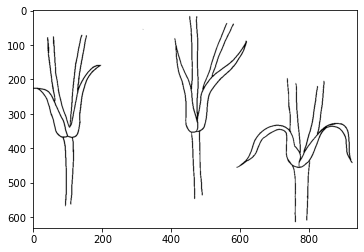

In [14]:
for i in range(1,30,1):
    print(i)
    #input address of ground truths
    name = '{}.jpg'.format(i)
    img_line = cv2.imread(name)

    coords_line = center_dots((img_line))
    
    #input address of sketches
    name = '{}.jpg'.format(i)
    dot = cv2.imread(name)
    size = dot.shape 

    img_ske =cv2.resize(dot,(size[1]*1,size[0]*1))
    #img_ske = dot

    coords_sketch = center_dots(img_ske)

    orderedCoords_sketch= np.zeros( [len(coords_sketch[0]),len(coords_sketch)] )

    orderedCoords_sketch[0] = (coords_sketch[0].max(),coords_sketch[1][coords_sketch[0].argmax()])
    orderedCoords_sketch[2] = (coords_sketch[0][coords_sketch[1].argmin()],coords_sketch[1].min())

    if coords_sketch[0].argmax() == 0 :
        if coords_sketch[1].argmin() == 1:
            orderedCoords_sketch[1] = (coords_sketch[0][2],coords_sketch[1][2])
        if coords_line[1].argmin() == 2:
            orderedCoords_sketch[1] = (coords_sketch[0][1],coords_sketch[1][1])

    if coords_sketch[0].argmax() == 1 :
        if coords_sketch[1].argmin() == 0:
            orderedCoords_sketch[1] = (coords_sketch[0][2],coords_sketch[1][2])
        if coords_line[1].argmin() == 2:
            orderedCoords_sketch[1] = (coords_sketch[0][0],coords_sketch[1][0])

    if coords_sketch[0].argmax() == 2 :
        if coords_sketch[1].argmin() == 0:
            orderedCoords_sketch[1] = (coords_sketch[0][1],coords_sketch[1][1])
        if coords_sketch[1].argmin() == 1:
            orderedCoords_sketch[1] = (coords_sketch[0][0],coords_sketch[1][0])

    orderedCoords_line= np.zeros( [len(coords_line[0]),len(coords_line)] )

    orderedCoords_line[0] = (coords_line[0].max(),coords_line[1][coords_line[0].argmax()])
    orderedCoords_line[2] = (coords_line[0][coords_line[1].argmin()],coords_line[1].min())


    if coords_line[0].argmax() == 0 :
        if coords_line[1].argmin() == 1:
            orderedCoords_line[1] = (coords_line[0][2],coords_line[1][2])
        if coords_line[1].argmin() == 2:
            orderedCoords_line[1] = (coords_line[0][1],coords_line[1][1])

    if coords_line[0].argmax() == 1 :
        if coords_line[1].argmin() == 0:
            orderedCoords_line[1] = (coords_line[0][2],coords_line[1][2])
        if coords_line[1].argmin() == 2:
            orderedCoords_line[1] = (coords_line[0][0],coords_line[1][0])

    if coords_line[0].argmax() == 2 :
        if coords_line[1].argmin() == 0:
            orderedCoords_line[1] = (coords_line[0][1],coords_line[1][1])
        if coords_line[1].argmin() == 1:
            orderedCoords_line[1] = (coords_line[0][0],coords_line[1][0])


    line= np.zeros((3,2))
    line[:,0]= orderedCoords_line[:,0]
    line [:,1]= orderedCoords_line[:,1]

    sketch= np.zeros((3,2))
    sketch[:,0]= orderedCoords_sketch[:,0]
    sketch[:,1]= orderedCoords_sketch[:,1]

    pts_s = sketch.astype('float32')
    pts_l = line.astype('float32')

    align_matrix = cv2.getAffineTransform(pts_l, pts_s)

    align_img = np.zeros(img_ske[:,:,1].shape, np.uint8);

    cols,rows,ch = (img_ske.shape)

    align_img = cv2.warpAffine(img_line,align_matrix, (rows,cols), flags=cv2.INTER_AREA, borderMode=cv2.BORDER_REPLICATE)

    gray_line = np.zeros(img_ske[:,:,1].shape, np.uint8)

    gray_line = cv2.cvtColor(align_img,cv2.COLOR_BGR2GRAY)

    line_bin = np.zeros(img_ske[:,:,1].shape, np.uint8)

    th, line_bin= cv2.threshold(gray_line, 254, 255, cv2.THRESH_OTSU)

    mask = np.zeros(img_ske[:,:,1].shape, np.uint8)

    cv2.circle(img=mask,center=(int(sketch[0][0]),int(sketch[0][1])),radius=10,color=255,thickness=-1)
    cv2.circle(img=mask,center=(int(sketch[1][0]),int(sketch[1][1])),radius=10,color=255,thickness=-1)
    cv2.circle(img=mask,center=(int(sketch[2][0]),int(sketch[2][1])),radius=10,color=255,thickness=-1)


    line_bin[mask == 255] = 255

    plt.imshow(line_bin ,cmap='gray')

    #input address of were you want the output saved
    sfile = '{}.jpg'.format(i)
    cv2.imwrite(sfile, (line_bin))